In [123]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib
import matplotlib.lines as mlines
import pickle as pk
pal = sns.color_palette()
list_colors_sns = pal.as_hex()

In [124]:
dataset = 'cifar100'
boo_name = 'BoostedNet'
w_name = 'L2W-DEN'
our_name = 'ConfEE'
model = 't2t_14' # t2t_x
long_name = model.split('_')[0] + '_vit_' + model.split('_')[1] # t2t_vit_x
if dataset == 'cifar10': 
    total_mudaa = 13.4
    end_acc = 94.5
    lambda_val_1 = 0.5
    lambda_val_2 = 0.9
    end_plot_acc = 0# 0.85*end_acc
    line_acc = end_acc*0.9
    line_acc_label =r'$90\%$ of end accuracy'
    L=7
elif dataset == 'cifar100':
    total_mudaa = 56
    end_acc = 88.4
    L=14
    lambda_val_1 = 0.8
    lambda_val_2 = 0.9
    end_plot_acc = 0.5*end_acc
    line_acc = end_acc*0.7
    line_acc_label =r'$70\%$ of end accuracy'
elif dataset == 'svhn':
    L=7
    end_acc = 92
    end_plot_acc = 0.7*end_acc
    line_acc = end_acc*0.8
    line_acc_label =r'$80\%$ of end accuracy'
    total_mudaa = 4.3
    lambda_val_1 = 0.1
    lambda_val_2 = 4

In [125]:
with open(dataset+'_'+model+'/'+long_name+'_boosted_'+dataset+'_results.pk', 'rb') as file:
        list_dict_boosted = pk.load(file)
        

# with open(dataset+'_'+model+'/'+long_name+'_baseline_'+dataset+'_results.pk', 'rb') as file:
#         list_dict_baseline = pk.load(file)

In [126]:
with open(dataset+'_'+model+'/'+long_name+'_weighted_'+dataset+'_results.pk', 'rb') as file:
        list_dict_weighted = pk.load(file)

In [127]:
path = dataset+'_'+model+'/'
list_files = os.listdir(path)

list_dicts_ours = []
for file_name in list_files:
   
    if '.pk' in file_name and 'baseline' not in file_name and 'boosted' not in file_name and 'weighted' not in file_name:
        lambda_val = float(file_name.split('_')[-2])
        print(file_name)
        with open(os.path.join(path, file_name), 'rb') as file:
            dicts = pk.load(file)
        dicts['lambda'] = lambda_val
        list_dicts_ours.append(dicts)
        print(lambda_val)
        if lambda_val == lambda_val_1:
            our_point_to_display = dicts
            print('got point 1')
        if lambda_val == lambda_val_2:
            our_point2_to_display = dicts
            print('got point 2')

09-21-2023_cifar100_t2t_vit_14_0.6_results.pk
0.6
09-19-2023_cifar100_1.5_results.pk
1.5
09-21-2023_cifar100_0.01_results.pk
0.01
09-22-2023_cifar100_t2t_vit_14_1.0_results.pk
1.0
09-20-2023_cifar100_1.0_results.pk
1.0
09-20-2023_cifar100_2.1_results.pk
2.1
09-22-2023_cifar100_t2t_vit_14_2.0_results.pk
2.0
09-20-2023_cifar100_2.0_results.pk
2.0
09-20-2023_cifar100_0.55_results.pk
0.55
09-21-2023_cifar100_t2t_vit_14_0.5_results.pk
0.5
09-22-2023_cifar100_t2t_vit_14_5.0_results.pk
5.0
09-21-2023_cifar100_t2t_vit_14_3.0_results.pk
3.0
09-21-2023_cifar100_t2t_vit_14_0.7_results.pk
0.7
09-20-2023_cifar100_3.0_results.pk
3.0
09-22-2023_cifar100_t2t_vit_14_0.9_results.pk
0.9
got point 2
09-20-2023_cifar100_5.0_results.pk
5.0
09-21-2023_cifar100_t2t_vit_14_0.8_results.pk
0.8
got point 1
09-19-2023_cifar100_0.8_results.pk
0.8
got point 1
09-21-2023_cifar100_t2t_vit_14_2.8_results.pk
2.8
09-21-2023_cifar100_t2t_vit_14_1.5_results.pk
1.5
09-20-2023_cifar100_10.0_results.pk
10.0
09-20-2023_cifar10

In [128]:
def extract_metrics_we_want(metrics_dict, keys_we_want):
    metrics_we_want = {}
    for key, val in metrics_dict.items():
        if key in keys_we_want:
            metrics_we_want[key] = val
    return metrics_we_want

def get_all_cov_C(metrics):
    cov_keys_dict = {}
    C_keys_dict = {}
    for key in metrics.keys():
        if 'emp_alpha' in key:
            tokens = key.split('emp_alpha')
            alpha = tokens[1]
            prefix = tokens[0]
            
            cov_key = prefix+'emp_alpha'+alpha
            C_key = prefix+'C'+alpha
            if prefix in cov_keys_dict:
                cov_keys_dict[prefix].append(cov_key)
                C_keys_dict[prefix].append(C_key)
            else:
                cov_keys_dict[prefix] = [cov_key] 
                C_keys_dict[prefix] = [C_key]  
    return cov_keys_dict, C_keys_dict

def get_all_key_with(metrics, substring):
    keys_with_substring = []
    for key in metrics.keys():
        if substring in key:
            keys_with_substring.append(key)
    return keys_with_substring

def find_highest_cov(metrics_we_care_about, cov_keys, requested_alpha):
    alpha_max = 0
    for cov_key in cov_keys:
            alpha_val = float(cov_key.split('_')[-1])
            emp_alpha = metrics_we_care_about['average'+cov_key]
            if emp_alpha< requested_alpha:
                if alpha_max < alpha_val:
                    alpha_max = alpha_val
                    #print('switching fot', alpha_val)
    #print('highest alpha is ', alpha_max, 'with emp cov', )
    return alpha_max
            

In [129]:
our_df = pd.DataFrame()
keys_ece = get_all_key_with(list_dicts_ours[-1], 'test/ece')
keys_we_want = ['test/acc_exit','test/total_cost', 'test/gated_acc', 'test/gated_ece', 'test/gated_ece']
cov_keys_dict, C_keys_dict = get_all_cov_C(list_dicts_ours[0])


type_of_conf = 'test/sets_general_'
cov_keys = cov_keys_dict[type_of_conf]
C_keys = C_keys_dict[type_of_conf]
cov_keys_baseline = cov_keys
C_keys_baseline = C_keys
# cov_keys_baseline = [c.split('test/')[-1] for c in cov_keys] # dumb storing thing, have to remove the test/ fo rhte baseline
# C_keys_baseline = [c.split('test/')[-1] for c in C_keys] 

print(cov_keys)
print(cov_keys_baseline)
keys_we_want = keys_we_want + cov_keys + C_keys +keys_ece
keys_gated_accs = get_all_key_with(list_dicts_ours[-1], 'gated_acc_')
keys_all_acc = get_all_key_with(list_dicts_ours[-1], 'test/acc')




['test/sets_general_emp_alpha_0.01', 'test/sets_general_emp_alpha_0.015', 'test/sets_general_emp_alpha_0.02', 'test/sets_general_emp_alpha_0.025', 'test/sets_general_emp_alpha_0.03', 'test/sets_general_emp_alpha_0.035', 'test/sets_general_emp_alpha_0.04', 'test/sets_general_emp_alpha_0.045', 'test/sets_general_emp_alpha_0.05']
['test/sets_general_emp_alpha_0.01', 'test/sets_general_emp_alpha_0.015', 'test/sets_general_emp_alpha_0.02', 'test/sets_general_emp_alpha_0.025', 'test/sets_general_emp_alpha_0.03', 'test/sets_general_emp_alpha_0.035', 'test/sets_general_emp_alpha_0.04', 'test/sets_general_emp_alpha_0.045', 'test/sets_general_emp_alpha_0.05']


In [130]:
keys_we_want

['test/acc_exit',
 'test/total_cost',
 'test/gated_acc',
 'test/gated_ece',
 'test/gated_ece',
 'test/sets_general_emp_alpha_0.01',
 'test/sets_general_emp_alpha_0.015',
 'test/sets_general_emp_alpha_0.02',
 'test/sets_general_emp_alpha_0.025',
 'test/sets_general_emp_alpha_0.03',
 'test/sets_general_emp_alpha_0.035',
 'test/sets_general_emp_alpha_0.04',
 'test/sets_general_emp_alpha_0.045',
 'test/sets_general_emp_alpha_0.05',
 'test/sets_general_C_0.01',
 'test/sets_general_C_0.015',
 'test/sets_general_C_0.02',
 'test/sets_general_C_0.025',
 'test/sets_general_C_0.03',
 'test/sets_general_C_0.035',
 'test/sets_general_C_0.04',
 'test/sets_general_C_0.045',
 'test/sets_general_C_0.05',
 'test/ece0',
 'test/ece1',
 'test/ece2',
 'test/ece3',
 'test/ece4',
 'test/ece5',
 'test/ece6',
 'test/ece7',
 'test/ece8',
 'test/ece9',
 'test/ece10',
 'test/ece11',
 'test/ece12']

In [131]:
requested_alpha = 0.05

In [132]:
our_df = pd.DataFrame()
for metrics in list_dicts_ours:
   
    metrics_we_care_about = extract_metrics_we_want(metrics, keys_we_want)
    metrics_we_care_about['average_IC'] = np.mean(metrics_we_care_about['test/total_cost'])/total_mudaa
    metrics_we_care_about['average_ACC'] = np.mean(metrics_we_care_about['test/gated_acc'])
    metrics_we_care_about['ACC'] = metrics_we_care_about['test/gated_acc'] 
    
    metrics_we_care_about['ECE'] =metrics_we_care_about['test/gated_ece'] 
    
    for cov_key in cov_keys:
        alpha = float(cov_key.split('alpha_')[-1])
        
        metrics_we_care_about['average'+cov_key] = np.mean(metrics_we_care_about[cov_key])
        
        metrics_we_care_about['alpha'+cov_key] = alpha
    for C_key in C_keys:
        metrics_we_care_about['average'+C_key] = np.mean(metrics_we_care_about[C_key])
        
    alpha_max = find_highest_cov(metrics_we_care_about, cov_keys, requested_alpha)
    
    
    if alpha_max >0 :
        C_key = type_of_conf+'C_'+str(alpha_max)
        
        metrics_we_care_about['C'] = metrics_we_care_about[C_key]
        metrics_we_care_about['emp_alpha'] = alpha_max
    
    df = pd.DataFrame(data=metrics_we_care_about)
    
    our_df = pd.concat([df, our_df],axis=0, ignore_index=True)
    



our_df['method'] = our_name

In [133]:
def replace_if_closer(points,closest_to_points, val, this_point):
    for i, point in enumerate(points):
        dif_now = np.abs(val-point)
        #print(dif_now)
        dif_prev = closest_to_points[i][1]
        if dif_now< dif_prev:
            closest_to_points[i] = (this_point, dif_now)
    return closest_to_points
def collect_baseline_data(list_dict_baseline, points):
    baseline_df = pd.DataFrame()
    closest_to_points = [(None, 100) for _ in points]
    for metrics in list_dict_baseline:
        metrics['average_IC'] = np.mean(metrics['EXPECTED_FLOPS'])/total_mudaa
        metrics['average_ACC'] = np.mean(metrics['ACC'])
        ic = np.mean(metrics['EXPECTED_FLOPS'])
        
        closest_to_points = replace_if_closer(points,closest_to_points, ic, metrics)
 
        for cov_key in cov_keys_baseline:
            alpha = float(cov_key.split('alpha_')[-1])
            metrics['average'+cov_key] = np.mean(metrics[cov_key])
            metrics['alpha'+cov_key] = float(cov_key.split('_')[-1])
        for C_key in C_keys_baseline:
            metrics['average'+C_key] = np.mean(metrics[C_key])
            
        alpha_max = find_highest_cov(metrics, cov_keys_baseline, requested_alpha)
        
        if alpha_max >0 :
            C_key = type_of_conf+'C_'+str(alpha_max)
            metrics['C'] = metrics[C_key]
            metrics['emp_alpha'] = alpha_max
        df = pd.DataFrame(data=metrics)
        baseline_df = pd.concat([df, baseline_df],axis=0, ignore_index=True)
    return baseline_df, [tuple_points[0] for tuple_points in closest_to_points]

our_point_ic  = np.mean(our_point_to_display['test/total_cost'])
our_point_acc  = np.mean(our_point_to_display['test/gated_acc'])
boosted_df, boosted_points = collect_baseline_data(list_dict_boosted, [our_point_ic, our_point2_ic])
boosted_df['method'] = boo_name
weighted_df, weighted_points = collect_baseline_data(list_dict_weighted, [our_point_ic, our_point2_ic])
weighted_df['method'] = w_name
our_point_ic = our_point_ic/

/tmp/ipykernel_17869/1385163021.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  boosted_df['method'] = boo_name
/tmp/ipykernel_17869/1385163021.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  weighted_df['method'] = w_name


In [134]:
boosted_point_ic  = np.mean(boosted_points[0]['average_IC'])
boosted_point_acc  = np.mean(boosted_points[0]['ACC'])

weighted_point_ic  = np.mean(weighted_points[0]['average_IC'])
weighted_point_acc  = np.mean(weighted_points[0]['ACC'])


0.13407279423304966
9.479999999999999


In [135]:
filtered_boosted_df = boosted_df[boosted_df['average_ACC'].between(end_plot_acc, end_acc)]
filtered_our_df = our_df[our_df['average_ACC'].between(end_plot_acc, end_acc)]
filtered_weighted_df = weighted_df[weighted_df['average_ACC'].between(end_plot_acc, end_acc)]
#filtered_baseline_df   = baseline_df[baseline_df['average_ACC'].between(end_plot_acc, end_acc)]


In [136]:
combined_df = pd.concat([filtered_boosted_df, filtered_weighted_df, filtered_our_df],axis=0, ignore_index=True)

In [137]:
#combined_df = pd.concat([filtered_weighted_df, filtered_our_df],axis=0, ignore_index=True)

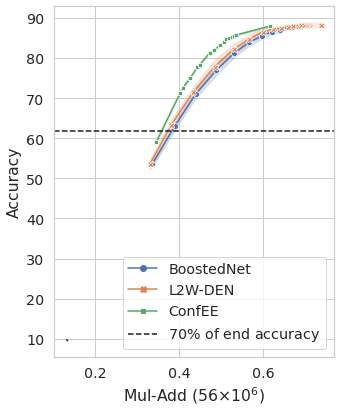

In [139]:

plt.figure(figsize=(5,6))
sns.set_theme(style="whitegrid",font_scale=1.3)
sns.lineplot(data=combined_df, x="average_IC", y="ACC", hue="method", style="method",
    markers=True, dashes=False)
plt.axhline(y=line_acc, color='k',linestyle='--', label=line_acc_label)
plt.plot([boosted_point_ic,weighted_point_ic],[boosted_point_acc,weighted_point_acc],color='k')
plt.legend()
x_string = r'Mul-Add ('+str(total_mudaa)+'$ \\times 10^6$)'
plt.xlabel(x_string)
plt.ylabel('Accuracy')
plt.tight_layout()
plt.savefig('figures/perf_cost_'+dataset+'.pdf')

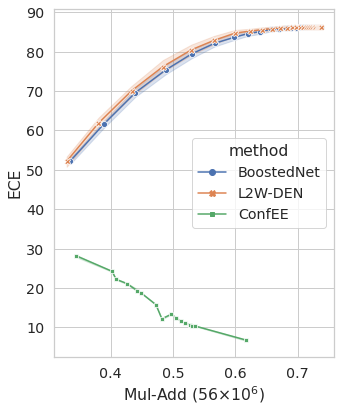

In [64]:

plt.figure(figsize=(5,6))
sns.set_theme(style="whitegrid",font_scale=1.3)
sns.lineplot(data=combined_df, x="average_IC", y="ECE", hue="method", style="method",
    markers=True, dashes=False)


plt.xlabel(x_string)
plt.ylabel('ECE')
plt.tight_layout()
plt.savefig('figures/perf_ece_'+dataset+'.pdf')

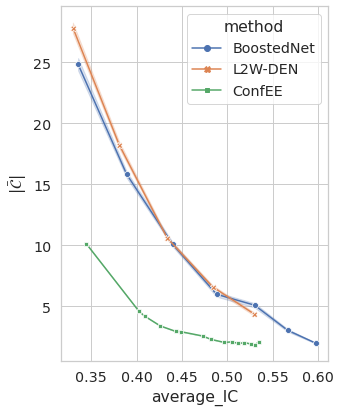

In [65]:

plt.figure(figsize=(5,6))
sns.set_theme(style="whitegrid",font_scale=1.3)
sns.lineplot(data=combined_df, x="average_IC", y="C", hue="method", style="method",
    markers=True, dashes=False)


x_string = r'Mul-Add ('+str(total_mudaa)+'$ \\times 10^6$)'
plt.ylabel(r'$|\mathcal{\bar{C}}|$')
plt.tight_layout()
plt.savefig('figures/inef_IC_'+dataset+'.pdf')


In [66]:
weighted_df_emp_vs_req = pd.DataFrame()
boosted_df_emp_vs_req = pd.DataFrame()
our_df_emp_vs_req = pd.DataFrame()
for cov_key in cov_keys_baseline:
    print(cov_key)
    alpha = float(cov_key.split('alpha_')[-1])
    boosted_df_cov = pd.DataFrame()
    boosted_df_cov['emp_alpha'] = boosted_df[cov_key]
    boosted_df_cov['requested_alpha'] = alpha
    boosted_df_emp_vs_req = pd.concat([boosted_df_cov, boosted_df_emp_vs_req],axis=0, ignore_index=True)

    df_cov = pd.DataFrame()
    df_cov['emp_alpha'] = weighted_df[cov_key]
    df_cov['requested_alpha'] = alpha
    weighted_df_emp_vs_req = pd.concat([df_cov, weighted_df_emp_vs_req],axis=0, ignore_index=True)

    df_cov = pd.DataFrame()
    df_cov['emp_alpha'] = our_df[cov_key]
    df_cov['requested_alpha'] = alpha
    our_df_emp_vs_req = pd.concat([df_cov, our_df_emp_vs_req],axis=0, ignore_index=True)
    

test/sets_general_emp_alpha_0.01
test/sets_general_emp_alpha_0.015
test/sets_general_emp_alpha_0.02
test/sets_general_emp_alpha_0.025
test/sets_general_emp_alpha_0.03
test/sets_general_emp_alpha_0.035
test/sets_general_emp_alpha_0.04
test/sets_general_emp_alpha_0.045
test/sets_general_emp_alpha_0.05


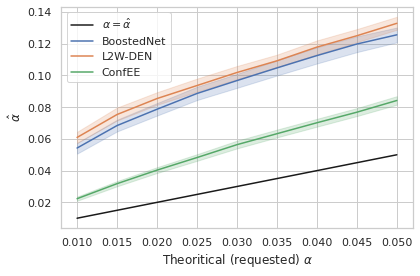

In [67]:
x = [0.01,0.05]
y = [0.01,0.05]
sns.set_theme(style="whitegrid")
plt.plot(x,y, color='k',label=r'$\alpha = \hat{\alpha}$')
sns.lineplot(data=boosted_df_emp_vs_req, x="requested_alpha", y="emp_alpha", label=boo_name)
sns.lineplot(data=weighted_df_emp_vs_req, x="requested_alpha", y="emp_alpha", label=w_name)
sns.lineplot(data=our_df_emp_vs_req, x="requested_alpha", y="emp_alpha", label=our_name)

plt.xlabel(r'Theoritical (requested) $\alpha$')
plt.ylabel(r' $\hat{\alpha}$')
plt.tight_layout()
plt.savefig('figures/emp_vs_theoritical_'+dataset+'.pdf')

In [68]:
num_exit_key = r'$|\mathcal{D}^l|$ (gate usage)'
def aggregate_acc_baseline(w_metrics, delta):
    df_acc_cum = pd.DataFrame()
    cumul_acc = 0
    for l in range(L):
        all_acc = 'ALL_ACC_PER_GATE_'+str(l)
        gated_acc = 'GATED_ACC_PER_GATE_'+str(l)
        num_exit = 'EXIT_RATE_PER_GATE_'+str(l)
        df_acc = pd.DataFrame()
        df_acc['constant'] = 5
        df_acc['all'] = w_metrics[all_acc]
        if gated_acc in w_metrics:
           
            df_acc['gated'] = w_metrics[gated_acc]
            
            df_acc['gate'] = l+delta
            df_acc[num_exit_key] = np.mean(w_metrics[num_exit])
            
            frac = np.mean(metrics[num_exit])
            g_all = np.mean(metrics[gated_acc])
            
            ammount_acc = (frac * g_all)/100.0
            cumul_acc = cumul_acc + ammount_acc
            df_acc['cumul_acc'] = cumul_acc
            df_acc_cum = pd.concat([df_acc_cum, df_acc],axis=0, ignore_index=True)
    return df_acc_cum

def aggregate_acc_ours(our_m, delta):
    df_acc_ours = pd.DataFrame()
    cumul_acc = 0
    for l in range(L):
        
        all_acc = 'test/acc'+str(l)

        gated_acc = 'test/gated_acc_'+str(l)
        percent_exit = 'test/percent_exit'+str(l)
        df_acc = pd.DataFrame()
        df_acc['all'] = our_m[all_acc]
        df_acc['constant'] = 5
        
        if gated_acc in our_m and len(our_m[gated_acc]) == 10:

            df_acc['gated'] = our_m[gated_acc]
            df_acc['gate'] = l
            frac = np.mean(our_m[percent_exit])
            g_all = np.mean(our_m[gated_acc])
            
            s = np.mean([100*p for p in our_m[percent_exit]])
            
            df_acc[num_exit_key] = s
            df_acc_ours = pd.concat([df_acc_ours, df_acc],axis=0, ignore_index=True)
            ammount_acc = (frac * g_all)/100.0
            cumul_acc = cumul_acc + ammount_acc
            df_acc['cumul_acc'] = cumul_acc
        
    return df_acc_ours
    
def plotting_point(point,b_metrics, w_metrics, prefix):
    delta = 0.1
    df_acc_ours = aggregate_acc_ours(point, delta)
    df_acc_ours['method'] = our_name      

    df_acc_boosted = aggregate_acc_baseline(b_metrics, delta)
    df_acc_boosted['method'] = boo_name      

    
   
    df_acc_weighted = aggregate_acc_baseline(w_metrics, delta*2)
    df_acc_weighted['method'] = w_name

    df_acc =  pd.concat([df_acc_boosted,df_acc_weighted, df_acc_ours],axis=0, ignore_index=True)
    
    
    
    
    sns.set(style="whitegrid", font_scale=1.6)
   
    g = sns.relplot(
        data=df_acc,
        x="gate", y="gated", hue='method',  size=num_exit_key,
         sizes=(5, 300))
    plt.ylim([0,105])
    plt.xlim([0,14])
    g.fig.set_size_inches(7,7)
    plt.axhline(np.mean(b_metrics['ACC']), color=list_colors_sns[0], linestyle='--')
    plt.axhline(np.mean(w_metrics['ACC']), color=list_colors_sns[1],linestyle= '--')
    plt.axhline(np.mean(point['test/gated_acc']), color=list_colors_sns[2], linestyle='--')
    legend1 = plt.legend([our_name +r' accuracy ', boo_name +' accuracy', w_name +' accuracy'], loc=4)
    
    plt.gca().add_artist(legend1)
    
    g.despine(left=True, bottom=True)
    g.set(xlabel ="Gates ($l$)", ylabel = r"Accuracy on exited points ($\mathcal{D}^l$)")
    g._legend.remove()
    plt.tight_layout()
    
    plt.savefig(prefix+'_'+dataset+'gated_acc.pdf')
    
    sns.set(style="whitegrid", font_scale=1.6)
    
    g = sns.relplot(
        data=df_acc,
        x="gate", y="all", hue='method',  size=num_exit_key,
         sizes=(5, 300), legend='brief')
   
    g.despine(left=True, bottom=True)
    plt.axhline(np.mean(b_metrics['ACC']), color=list_colors_sns[0], linestyle='--')
    plt.axhline(np.mean(w_metrics['ACC']), color=list_colors_sns[1],linestyle= '--')
    plt.axhline(np.mean(point['test/gated_acc']), color=list_colors_sns[2], linestyle='--')
    g.fig.set_size_inches(7,7)
    plt.ylim([0,105])
    plt.xlim([0,14])
    
    g.set(xlabel ="Gates ($l$)", ylabel = r"Accuracy on all points ($\mathcal{D}$)")
    
    plt.tight_layout()
   
    plt.savefig(prefix+'_'+dataset+'all_acc.pdf')

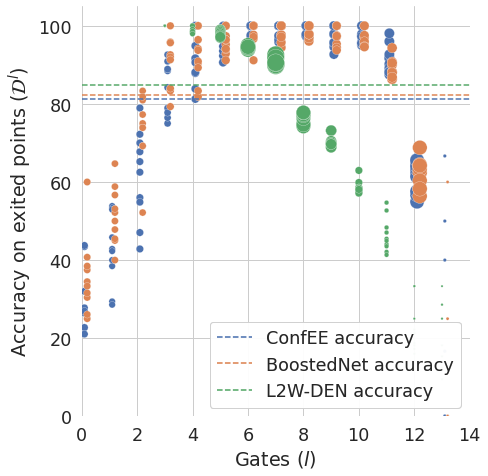

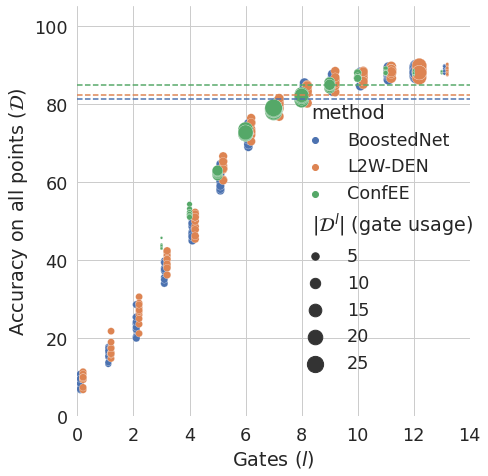

In [69]:
point = our_point_to_display
metrics = boosted_points[0]
w_metrics = weighted_points[0]
plotting_point(point,metrics, w_metrics,prefix='figures/better' )


In [70]:
print(g)

NameError: name 'g' is not defined

[86.4, 78.8, 81.4, 81.4, 82.6, 81.2, 85.4, 82.4, 81.2, 82.2]

In [72]:
our_df['test/ece0']

KeyError: 'test/ece0'

[29.60622787475586,
 29.486623764038086,
 29.618192672729492,
 29.558387756347656,
 30.389638900756836,
 29.103893280029297,
 30.371700286865234,
 29.31319808959961,
 29.7736759185791,
 29.301237106323242]

[29.996739124298095,
 29.971318626403807,
 29.962843004862467,
 29.939164688587187,
 29.959653364944458,
 29.93044132900238,
 29.907865785326276,
 29.953371700286866,
 29.941573619418673,
 29.92884475440979]